In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks/LABS/")

Mounted at /content/gdrive


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from skimage.io import imread, imshow
from skimage import img_as_ubyte

from skimage.filters.rank import entropy, gradient
from skimage.filters import threshold_otsu
import skimage.filters.rank as skr 
from skimage.filters import rank, gaussian, sobel
from skimage.feature import canny

from skimage.feature import greycomatrix, greycoprops, peak_local_max
from skimage.morphology import disk, opening, closing
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.segmentation import mark_boundaries, watershed
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops,find_contours


# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

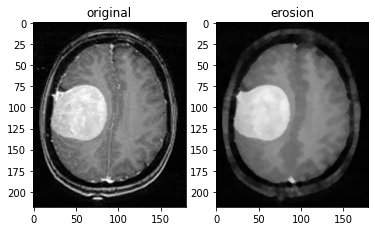

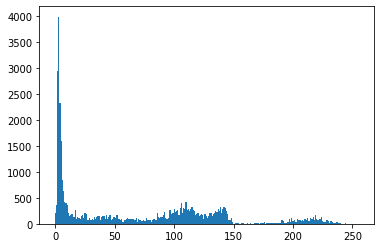

In [3]:
from skimage.io import imread,imshow
%matplotlib inline

def plot_hist(im):
  h,bins = np.histogram(im.flatten(),range(257))
  plt.figure()
  plt.bar(bins[:-1],h,bins[1]-bins[0])
  plt.show()

im = img_as_ubyte(imread("mri_brain.jpg", as_gray=True))

#im = imread('mri_brain.jpg')
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title("original")

# PREPROCESSING - Remove artifacts
im = closing(opening(im, disk(2)), disk(2))
plt.subplot(1,2,2)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title("erosion")
plt.show()

# HISTOGRAM
plot_hist(im)

# FIRST METHOD - OTSU THRESHOLD

AS THE TUMOR IS VERY CONTRASTED FROM THE REST OF THE IMAGE, IT COULD BE A RELATIVELY GOOD SOLUTION


In [4]:
# OTSU THRESHOLD
def getMask(im):
  T = threshold_otsu(im)
  mask = im>T
  return mask

def plot_otsu(im):
  otsu_mask = getMask(im)

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
  plt.title("original")
  plt.subplot(1,2,2)
  plt.imshow(otsu_mask, cmap=plt.cm.gray)
  plt.title("otsu")
  plt.show()

  return otsu_mask

## WITHOUT GAMMA CORRECTION
### not giving a good result


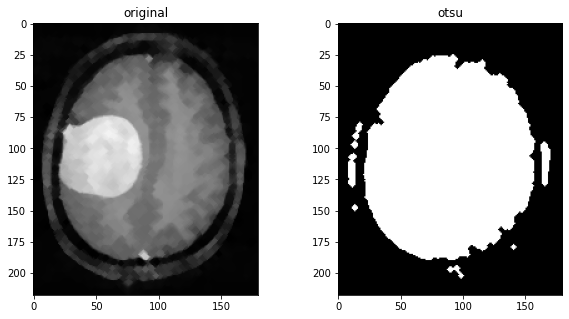

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
plot_otsu(im)

## WITH GAMMA CORECTION

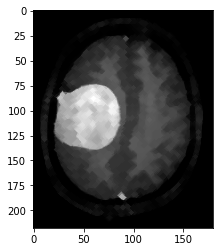

'\nim = adjust_gamma(im, gamma=2, gain=1)\nimshow(im)\n'

In [6]:
# ADJUST GAMMA -> MORE CONTRAST
from skimage.exposure import adjust_gamma
def lut_gamma(gamma):
    lut = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)
    return lut 

lut = lut_gamma(2.0)
im = lut[im]
plt.figure()
plt.imshow(im,cmap=cm.gray)
plt.show()

# BUILT IN FCT
"""
im = adjust_gamma(im, gamma=2, gain=1)
imshow(im)
"""

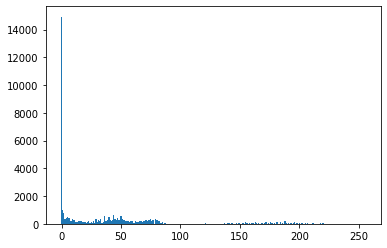

In [7]:
plot_hist(im)

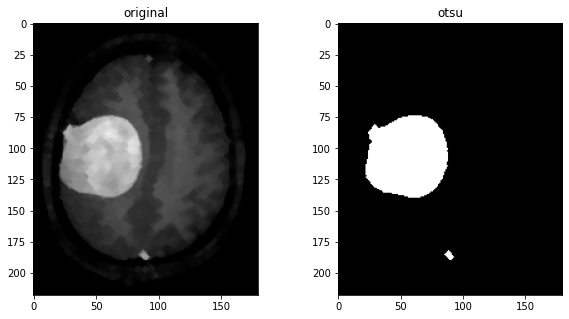

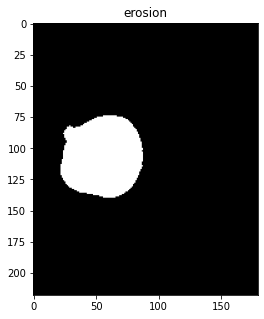

In [8]:
otsu_mask = plot_otsu(im)

# Removing artifacts
otsu_mask_clean = closing(opening(otsu_mask, disk(3)), disk(1))
plt.figure(figsize=(5,5))
plt.imshow(otsu_mask_clean, cmap=plt.cm.gray)
plt.title("erosion")
plt.show()

In [9]:
print("Surface: %d cm² " % (0.115 * 0.115 * otsu_mask_clean.sum()))

Surface: 46 cm² 


# SECOND METHOD - REGION GROWING
## WATERSHED TRANSFORM 
### THE BORDERS ARE GUARANTEED TO BE CLOSED

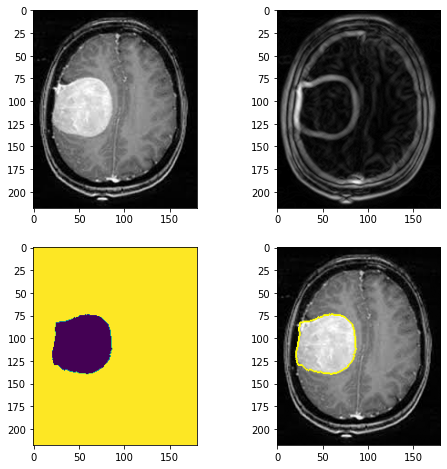

In [10]:
#im = imread('mri_brain.jpg')
im = img_as_ubyte(imread("mri_brain.jpg", as_gray=True))

smoothing_factor = 4
# Compute the edges of the image:
edge = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

#### USING SOBEL
#edge = sobel(skr.mean(im, disk(smoothing_factor)))

#### USING CANNY
#edge = canny(skr.mean(im, disk(smoothing_factor)), sigma=3.)

# Manually selected markers
markers_coordinates = [
    [110,50], # Tumor
    [137, 107] #outside
    ]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(edge, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(edge,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

In [11]:
mask = ws 
mask -= 1
inverted_mask=1-mask
sum_mask = inverted_mask.sum()

In [12]:
print(sum_mask)

3500


In [13]:
print("Surface: %d cm² " % (0.115 * 0.115 * sum_mask))

Surface: 46 cm² 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


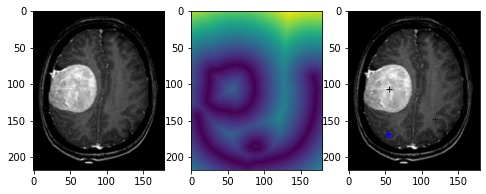

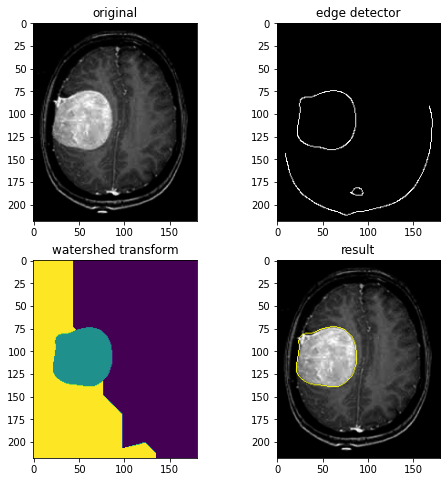

In [14]:
# Variant - Automatic marker

from scipy.ndimage import distance_transform_edt
from skimage import util 
from skimage.feature import peak_local_max

im = img_as_ubyte(imread("mri_brain.jpg", as_gray=True))

plt.figure(figsize=[8,8])

####### enhance contrast
im = adjust_gamma(im, gamma=2, gain=1)
plt.subplot(1,3,1)
plt.imshow(im, cmap=plt.cm.gray)

####### edge detector
edge = canny(skr.mean(im, disk(smoothing_factor)), sigma=3.)

################
#edge = skr.gradient(im.astype(np.uint8), disk(4))
################

#invert image
inverted_img = util.invert(edge)

####### get distance from borders
distance = distance_transform_edt(inverted_img)
plt.subplot(1,3,2)
plt.imshow(distance)

####### find markers
markers = peak_local_max(distance, min_distance=20, indices=True)
plt.subplot(1,3,3)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
for m in markers:
    plt.plot(m[1],m[0],'b+')
plt.show()

####### apply watershed transform
#markers = peak_local_max(distance, min_distance=20, indices=False)
markers_t = np.zeros_like(im)
for i,(row,col) in enumerate(markers):
    markers_t[row,col] = i+1
ws = watershed(edge, markers_t)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.title("original")
plt.subplot(2,2,2)
plt.imshow(edge,cmap=plt.cm.gray);
plt.title("edge detector")
plt.subplot(2,2,3)
plt.imshow(ws);
plt.title("watershed transform")
ws[ws!=2] = 0
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));
plt.title("result")
plt.show()

# ENTROPY SEGMENTATION
## No blur

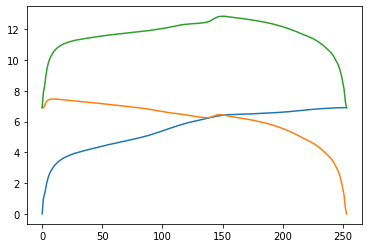

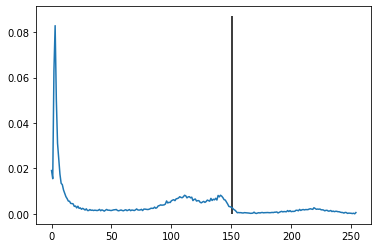

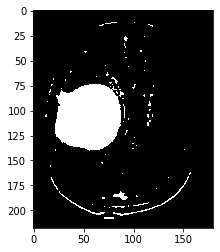

In [15]:
ima = img_as_ubyte(imread("mri_brain.jpg", as_gray=True))

h,_ = np.histogram(ima[:],range(256))
h = h/h.sum() # normalized histogram

def entropy(symb,freq):
    idx = np.asarray(freq) != 0
    s = np.sum(freq)
    p = 1. * freq/s
    e = - np.sum(p[idx] * np.log2(p[idx]))
    return e

e0 = []
e1 = []

for g in range(1,255):
    e0.append(entropy(range(0,g),h[:g]))
    e1.append(entropy(range(g,255),h[g:255]))

e0 = np.asarray(e0)
e1 = np.asarray(e1)

e_max = np.argmax(e0+e1)
plt.plot(e0)
plt.plot(e1)
plt.plot(e0+e1)

plt.figure()
plt.plot(h)
plt.gca().vlines(e_max,0,plt.gca().get_ylim()[1]);
plt.figure()
plt.imshow(ima>e_max,cmap=plt.cm.gray);

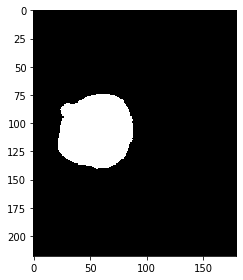

In [16]:
clean_im = closing(opening(ima>e_max, disk(3)), disk(1))
imshow(clean_im)